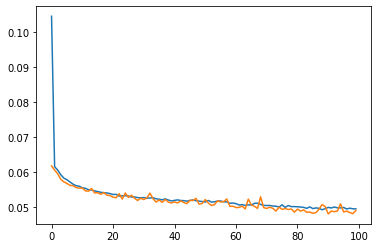

In [6]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, LeakyReLU, \
    Concatenate
import matplotlib.pyplot as plt
from keras import backend as K

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Translation of data
x_train_re = x_train.reshape(60000, 784).astype('float32')
x_test_re = x_test.reshape(x_test.shape[0], 784).astype('float32')
xtrain = x_train_re / 255
xtest = x_test_re / 255

inputs = Input(shape=(784,), name='1a')
x = Dense(256, name='1b')(inputs)
x = LeakyReLU(0.2)(x)
x = Dense(128, name='1c')(x)
x = LeakyReLU(0.2)(x)
x = Dense(10, name='1d')(x)
x = LeakyReLU(0.2)(x)
x = Dense(1, name='pca_1a')(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization(name='bn1')(x)
x = Dense(10, name='pca_1b')(x)
x = LeakyReLU(0.2)(x)
x = Dense(128, name='1f')(x)
x = LeakyReLU(0.2)(x)
x = Dense(256, name='1g')(x)
x = LeakyReLU(0.2)(x)
x = Dense(784, activation='sigmoid', name='1h')(x)
pcaae1 = Model(inputs, x)
pcaae1.compile(optimizer='adam', loss='mean_squared_error')
history1 = pcaae1.fit(xtrain, xtrain, epochs=100, batch_size=500, validation_split=0.2, verbose=0)
plt.plot(history1.history['loss'], label='1')
plt.plot(history1.history['val_loss'], label='1_val')

pcaae1.save('ae1.h5')
pcaae1.save_weights('ae1weight.h5')

q1 = Model(pcaae1.input, pcaae1.get_layer('bn1').output)
q1.save_weights('encoder1weight.h5')
cov1 = q1.predict(xtest)

===================stage2


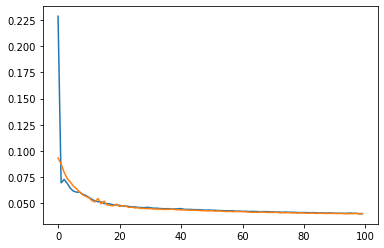

In [7]:
def model1(input1):
    x1 = Dense(256, name='1b')(input1)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Dense(128, name='1c')(x1)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Dense(10, name='1d')(x1)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Dense(1, name='pca_1a')(x1)
    x1 = LeakyReLU(0.2)(x1)
    x1 = BatchNormalization(name='bn1')(x1)
    model = Model(input1, x1)
    return model


def model2(input2):
    x2 = Dense(256, name='2b')(input2)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Dense(128, name='2c')(x2)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Dense(10, name='2d')(x2)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Dense(1, name='pca_2a')(x2)
    x2 = LeakyReLU(0.2)(x2)
    x2 = BatchNormalization(name='bn2')(x2)
    model = Model(input2, x2)
    return model


def pcaae2():
    input1 = Input(shape=(784,), name='1a')
    input2 = Input(shape=(784,), name='2a')

    model_1 = model1(input1)
    model_1.load_weights('encoder1weight.h5')

    for layer in model_1.layers:
        layer.trainable = False

    model_2 = model2(input2)
    model_2.load_weights('encoder1weight.h5')
    r1 = model_1.output
    r2 = model_2.output

    x3 = Concatenate(name='concat')([r1, r2])

    x = Dense(10, name='pca_2b')(x3)
    x = LeakyReLU(0.2)(x)
    x = Dense(128, name='2f')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, name='2g')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(784, activation='sigmoid', name='2h')(x)

    model = Model([input1, input2], outputs=x)
    ss = K.square(K.mean(r1 * r2))
    lo1 = K.mean(K.square(input1 - x), axis=-1)

    lo = lo1 * 1 + ss * 1
    return model, lo


print('===================stage2')
pcaae2, lo2 = pcaae2()
pcaae2.add_loss(lo2)
pcaae2.compile(optimizer='adam')

history2 = pcaae2.fit([xtrain, xtrain], None, epochs=100, batch_size=500, validation_split=0.2, verbose=0)
plt.plot(history2.history['loss'], label='2')
plt.plot(history2.history['val_loss'], label='2_val')
pcaae2.save('ae2.h5')
pcaae2.save_weights('ae2weight.h5')

q2 = Model(pcaae2.input, pcaae2.get_layer('bn2').output)
q2.save_weights('encoder2weight.h5')

===================stage3


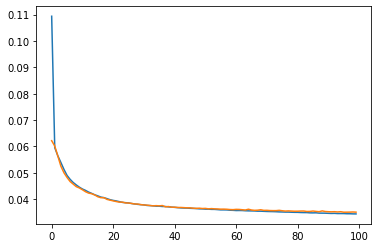

In [9]:
def model3(input3):
    x3 = Dense(256, name='3b')(input3)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Dense(128, name='3c')(x3)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Dense(10, name='3d')(x3)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Dense(1, name='pca_3a')(x3)
    x3 = LeakyReLU(0.2)(x3)
    x3 = BatchNormalization(name='bn3')(x3)
    model = Model(input3, x3)
    return model


def pcaae3():
    input1 = Input(shape=(784,), name='1a')
    input2 = Input(shape=(784,), name='2a')
    input3 = Input(shape=(784,), name='3a')

    model_1 = model1(input1)
    model_1.load_weights('encoder1weight.h5')
    for layer in model_1.layers:
        layer.trainable = False

    model_2 = model2(input2)
    model_2.load_weights('encoder2weight.h5')
    for layer in model_2.layers:
        layer.trainable = False

    model_3 = model3(input3)
    model_3.load_weights('encoder2weight.h5')

    r1 = model_1.output
    r2 = model_2.output
    r3 = model_3.output
    x3 = Concatenate(name='concat')([r1, r2, r3])

    x = Dense(10, name='pca_3b')(x3)
    x = LeakyReLU(0.2)(x)
    x = Dense(128, name='3f')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, name='3g')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(784, activation='sigmoid', name='3h')(x)

    model = Model([input1, input2, input3], outputs=x)
    cov = K.square(K.mean(r1 * r3))  + K.square(K.mean(r2 * r3)) 

    lo1 = K.mean(K.square(input1 - x), axis=-1)
    lo = lo1 + cov/2

    return model, lo
print('===================stage3')
pcaae3, lo3 = pcaae3()
pcaae3.add_loss(lo3)
pcaae3.compile(optimizer='adam')

history3 = pcaae3.fit([xtrain, xtrain, xtrain], None, epochs=100, batch_size=500, validation_split=0.2, verbose=0)
plt.plot(history3.history['loss'], label='3')
plt.plot(history3.history['val_loss'], label='3_val')

pcaae3.save('ae3.h5')
pcaae3.save_weights('ae3weight.h5')

q3 = Model(pcaae3.input, pcaae3.get_layer('bn3').output)

q3.save_weights('encoder3.h5')

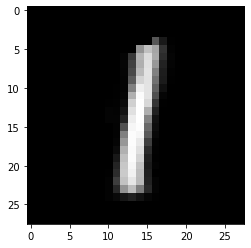

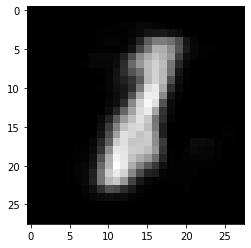

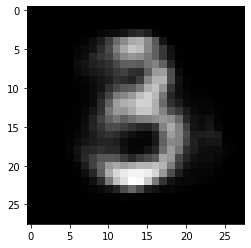

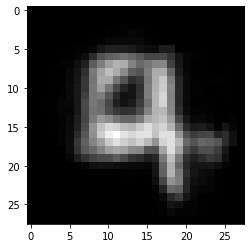

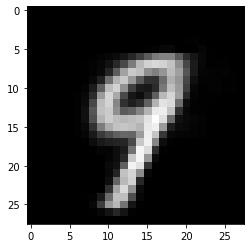

In [15]:
def f():
    inn = Input(shape=(3,), name='3a')
    x = Dense(10, name='pca_3b')(inn)
    x = LeakyReLU(0.2)(x)
    x = Dense(128, name='3f')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, name='3g')(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(784, activation='sigmoid', name='3h')(x)
    model = Model(inn, x)
    model.load_weights('ae3weight.h5', by_name=True)
    return model
a=f()
eigen1=[[-2,0,0],[-1,0,0],[0,0,0],[1,0,0],[2,0,0]]
eigen1=np.array(eigen1)
visual1=a.predict(eigen1)
for i in range(5):
  plt.imshow(visual1[i].reshape((28,28)),cmap='gray')
  plt.show()


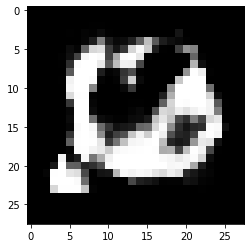

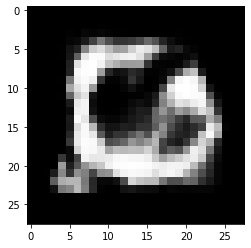

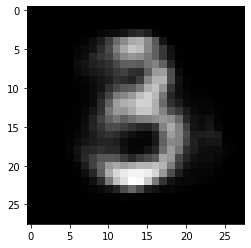

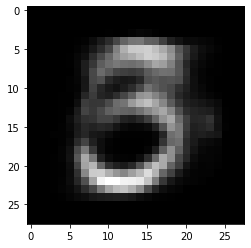

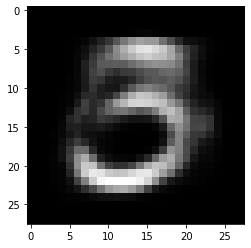

In [18]:
eigen2=[[0,-2,0],[0,-1,0],[0,0,0],[0,1,0],[0,2,0]]
eigen2=np.array(eigen2)
visual2=a.predict(eigen2)
for i in range(5):
  plt.imshow(visual2[i].reshape((28,28)),cmap='gray')
  plt.show()